# Trabajo Clustering
El objetivo de este trabajo es la realización de un estudio de *clustering* teniendo en cuenta los datos relativos a una encuesta sobre los desplazamientos de los ciudadanos llevada a cabo en Holanda entre los años 2010 y 2012. La técnica utilizada para ello será Fuzzy C-Means.

## Lectura y Visualización de los Datos
Antes de comenzar a trabajar con los datos proporcionados, se debe comenzar viendo cómo se encuentran orgnizados dentro del archivo. Para ello, se cargará dicho archivo y se procederá a la obtención de algunos datos a partir de este, como la cantidad de elementos, características o los diferentes valores que toman.

In [1]:
# Importación del paquete Pandas para la lectura del archivo.
import pandas as pd

In [2]:
# Carga del archivo con los datos.
data = pd.read_csv("./nts_data.csv")

In [3]:
# Visualización de los primeros elementos.
data.head(5)

,mode_main,distance,density,age,male,ethnicity,education,income,cars,license,bicycles,weekend,diversity,green,temp,precip,wind
0,walk,1.0,1.26259,84,no,native,lower,less20,0,yes,1,yes,1.24604,26.881233,0.1,0.10,3.0
1,walk,10.0,1.26259,84,no,native,lower,less20,0,yes,1,yes,1.24604,26.881233,0.1,0.10,3.0
2,car,3.0,1.76264,27,yes,western,middle,20to40,1,yes,2,yes,1.53959,36.045955,-3.4,0.05,1.8
3,car,3.0,1.76264,27,yes,western,middle,20to40,1,yes,2,yes,1.53959,36.045955,-3.4,0.05,1.8
4,car,61.5,1.76264,27,yes,western,middle,20to40,1,yes,2,yes,1.53959,36.045955,-3.4,0.05,1.8


In [4]:
print ("Características iniciales: " + str(len(data.columns)))
print ("Elementos totales: " + str(len(data.index)))

Características iniciales: 17
Elementos totales: 230608


In [5]:
# Visualización de los tipos de datos contenidos en el archivo.
data.dtypes

mode_main     object
distance     float64
density      float64
age            int64
male          object
ethnicity     object
education     object
income        object
cars           int64
license       object
bicycles       int64
weekend       object
diversity    float64
green        float64
temp         float64
precip       float64
wind         float64
dtype: object

Como se puede observar en el resultado de la ejecución de código anterior, existen diferentes tipos de valores en el archivo. No todos son de tipo cuantitativo, sino que también se encuentran datos de tipo cualitativo. Estos datos deberán transformarse para su posterior tratamiento a lo largo de este trabajo.

In [6]:
# Visualización de las variables cualitativas junto con el total de los diferentes valores que toma cada una.
catchar = list(data.select_dtypes(include=['object']))

for value in range(len(catchar)):
    print ("Valores diferentes para la característica '" + catchar[value] + "':")
    print data[catchar[value]].value_counts()
    
    if value != len(catchar) - 1:
        print ("\n")

Valores diferentes para la característica 'mode_main':
car     127439
bike     56298
walk     37571
pt        9300
Name: mode_main, dtype: int64


Valores diferentes para la característica 'male':
no     125676
yes    104932
Name: male, dtype: int64


Valores diferentes para la característica 'ethnicity':
native        201561
western        17772
nonwestern     11275
Name: ethnicity, dtype: int64


Valores diferentes para la característica 'education':
middle    88306
higher    79185
lower     63117
Name: education, dtype: int64


Valores diferentes para la característica 'income':
more40    106182
20to40     97140
less20     27286
Name: income, dtype: int64


Valores diferentes para la característica 'license':
yes    206986
no      23622
Name: license, dtype: int64


Valores diferentes para la característica 'weekend':
no     189250
yes     41358
Name: weekend, dtype: int64


Como resultado, se puede observar que no existen datos nulos, por lo que no es necesario el tratamiento de estos.

In [7]:
# Obtención de datos estadísticos de las variables cuantitativas iniciales.
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
distance,230608.0,12.217913,23.545686,0.10000,1.50000,4.000000,12.000000,400.000000
density,230608.0,1.569055,1.593292,0.00184,0.59132,1.153210,1.952960,11.442960
age,230608.0,47.661356,15.934884,18.00000,36.00000,47.000000,60.000000,98.000000
cars,230608.0,1.382584,0.822056,0.00000,1.00000,1.000000,2.000000,10.000000
bicycles,230608.0,3.357134,1.936614,0.00000,2.00000,3.000000,4.000000,10.000000
diversity,230608.0,1.774927,0.493037,0.00000,1.38894,1.827390,2.172380,2.827560
green,230608.0,54.939470,22.172372,0.00000,37.11120,54.102123,74.381844,97.813002
temp,230608.0,13.316930,7.565732,-9.00000,8.00000,13.400000,19.000000,35.900000
precip,230608.0,2.184633,4.674801,0.00000,0.00000,0.100000,2.300000,142.300000
wind,230608.0,4.097702,1.914821,0.40000,2.70000,3.800000,5.100000,16.300000


## Tratamiento y Graficado de los Datos Iniciales
En primer lugar, se procederá a graficar los histogramas para las diferentes características, de manera que se pueda visualizar cómo se encuentran distribuidos sus valores. La realización de este prodecimiento se debe a que en la tabla estadística se han detectado que algunas características como la distancia o la densidad tienen valores máximos muy alejados de la media.

In [8]:
# Importación de paquetes necesarios para la representación gráfica de los datos.
import matplotlib.pyplot as plt
import seaborn as sb

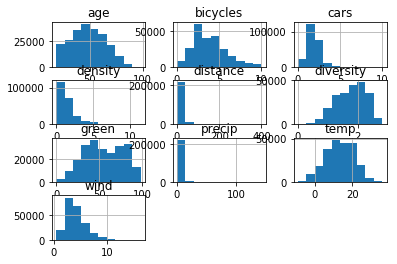

In [9]:
# Visualización de los valores del dataset
data.hist()
plt.show()

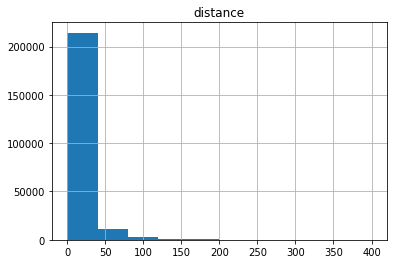

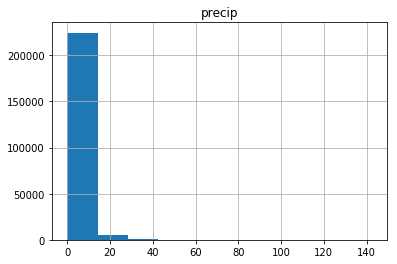

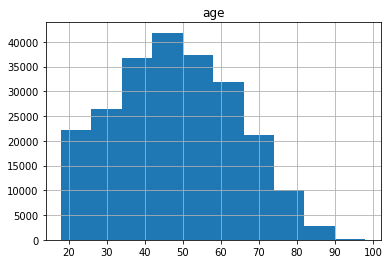

In [10]:
data.hist(column='distance')
data.hist(column='precip')
data.hist(column='age')
plt.show()

Como se puede observar, algunas de las variables poseen valores distribuidos de manera más homogénea que otras. Una vez que se dispone de una visualización rápida de los datos, se procede a realizar algunas transformaciones para la homogeneización de estos. Puesto que existen valores categóricos en alguna de las características, se procederá a su transformación numérica con respecto a unas reglas que se explican a continuación.

En el caso de que sean características cuyos valores tomen valores 'sí'/'no', se asignarán valores numéricos '1'/'0', respectivamente.

Por otra parte, en el caso de que las características tengan diferentes valores, se asignarán valores ascendentes (1, 2, 3, ...). De esta manera, aunque las características 'mode_main' o 'ethnicity' simplemente se clasificaran en la homogeneización, otras como 'education' e 'income' se verían mejor representadas, ya que conforme el nivel de educación o de ingresos sea mayor, el valor irá en aumento consecuentemente.

Por último, como se puede observar en los histogramas de las características, algunas de ellas presentan outliers más acusados. Por tanto, se utilizará el cálculo del z-score para descartar los elementos que se encuentren más allá de 3 desviaciones estándar con respecto a la media.

In [11]:
# Transformación de las características binarias (sí-no).
data['male'] = data['male'].map({'yes': 1, 'no': 0})
data['license'] = data['license'].map({'yes': 1, 'no': 0})
data['weekend'] = data['weekend'].map({'yes': 1, 'no': 0})

In [12]:
# Transformación del resto de características no numéricas.
data['mode_main'] = data['mode_main'].map({'bike': 1, 'car': 2, 'pt': 3, 'walk': 4})
data['ethnicity'] = data['ethnicity'].map({'native': 1, 'nonwestern': 2, 'western': 3})
data['education'] = data['education'].map({'lower': 1, 'middle': 2, 'higher': 3})
data['income'] = data['income'].map({'less20': 1, '20to40': 2, 'more40': 3})

In [13]:
# Importación de paquetes necesarios para el cálculo del z-score
from scipy import stats
import numpy as np

In [14]:
df_wo_outliers = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

A continuación, estandarizamos todos los datos para que tengan una igual relevancia en los cálculos posteriores. Para este propósito se utilizará el método "MinMaxScaler".

In [15]:
# Importación de paquetes necesarios para la estandarización
from sklearn import preprocessing

In [16]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_wo_outliers)
df_scaled = pd.DataFrame(x_scaled, columns=list(df_wo_outliers))
df_scaled.head(5)

/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,mode_main,distance,density,age,male,ethnicity,education,income,cars,license,bicycles,weekend,diversity,green,temp,precip,wind
0,1.0,0.010883,0.200140,0.857143,0.0,0.0,0.0,0.0,0.000000,1.0,0.111111,1.0,0.373502,0.254216,0.202673,0.006173,0.276596
1,1.0,0.119710,0.200140,0.857143,0.0,0.0,0.0,0.0,0.000000,1.0,0.111111,1.0,0.373502,0.254216,0.202673,0.006173,0.276596
2,1.0,0.004837,0.291797,0.376623,1.0,0.0,0.0,0.0,0.000000,1.0,0.333333,1.0,0.562542,0.357441,0.151448,0.003086,0.223404
3,1.0,0.004837,0.341596,0.376623,1.0,0.0,0.0,0.0,0.000000,1.0,0.333333,1.0,0.562542,0.357441,0.151448,0.003086,0.223404
4,1.0,0.003628,0.187148,0.168831,1.0,0.0,0.5,0.5,0.333333,1.0,0.222222,1.0,0.410105,0.841714,0.178174,0.000000,0.223404


A continuación, se graficarán los datos que se han obtenido, resultado de la estandarización de los valores. De modo que se pueda tener una representación visual de los mismos, observando la dispersión de cada una de las características.

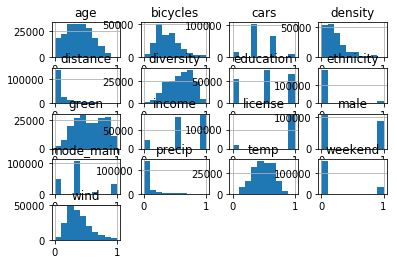

In [17]:
df_scaled.hist()
plt.show()

Para un primer graficado de los datos elegidos se han seleccionado las características 'distance', 'age' y 'precip', y se han agrupado según la característica 'income'. De esta manera, los datos quedarán clasificados según la distancia, edad y nivel de precipitación con respecto a los ingresos.

/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


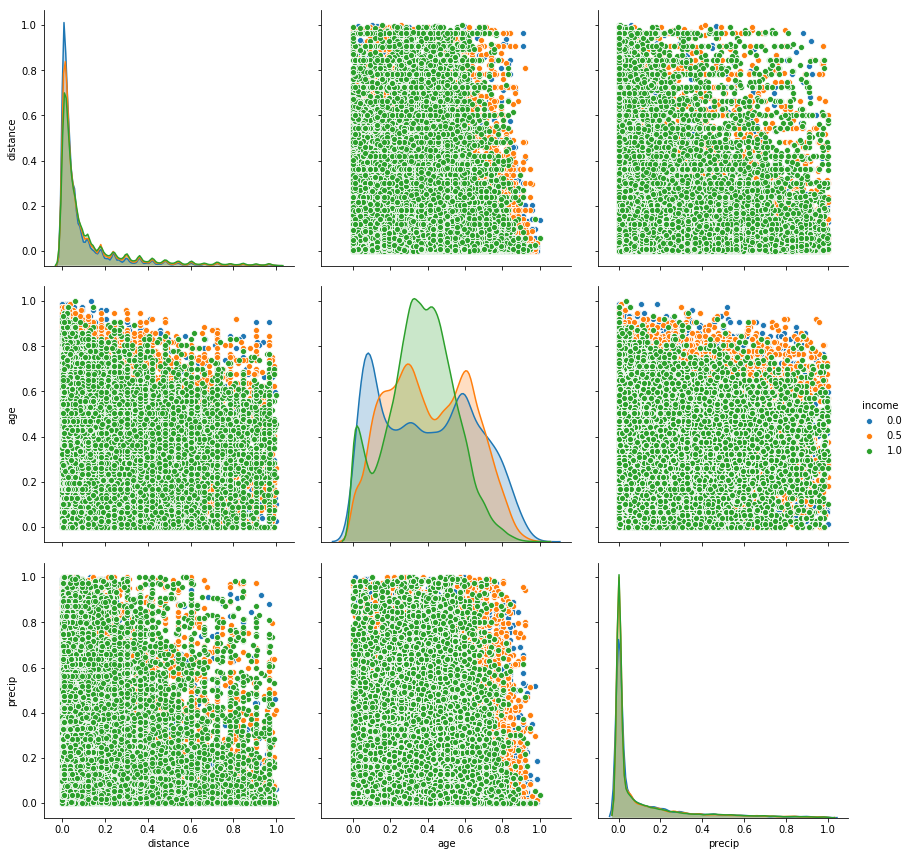

In [18]:
sb.pairplot(df_scaled, hue='income', height=4, vars=["distance", "age", "precip"], kind='scatter')

## Clustering
A partir de aquí, se llevará a cabo la tarea de clustering utilizando Fuzzy C-Means. Para ello, se ha decidido utilizar las características 'distance', 'precip' y 'income', de manera que se agrupen los trayectos por distancia, el nivel de precipitación y la cantidad de ingresos. Además, se va a realizar el clustering varias veces (entre 2 y 9) para determinar el FPC (Fuzzy Partition Coefficient), que indicará la mejor cantidad de *clusters* a utilizar. Por otra parte, se ha fijado una semilla para reducir el grado de aleatoriedad y conseguir resultados deterministas entre ejecuciones.

In [19]:
# Importación del paquete necesario para el uso de Fuzzy C-Means
import skfuzzy as fuzz

In [20]:
# Bucle para obtener resultados de FPC
fpcs = []
df_fuzzy = df_scaled[['distance', 'precip', 'income']].transpose()

for ncenters in range(2, 11):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(df_fuzzy, ncenters, 2, error=0.005, maxiter=1000, init=None, seed=13)
    fpcs.append(fpc)

Text(0,0.5,'Fuzzy Partition Coefficient')

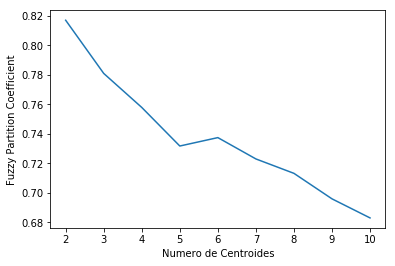

In [21]:
# Graficar FPC
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Numero de Centroides")
ax2.set_ylabel("Fuzzy Partition Coefficient")

Como se puede observar en el gráfico, el mejor valor para el FPC se obtiene con 2 clusters. A continuación, se imprimen los centroides de estos dos grupos.

In [22]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(df_fuzzy, 2, 2, error=0.005, maxiter=1000, init=None, seed=13)
print cntr

[[0.10921366 0.08994524 0.97546116]
 [0.08809452 0.0870591  0.41742151]]


Los resultados de los centroides de ambos *clusters* son similares, a excepción del último valor ('income'). Por tanto, estos resultados principalmente están agrupando los elementos con relación a los ingresos.

Por otra parte, en la gráfica del FPC anterior se produce un pico cuando se alcanza 6 como el número de *clusters*, por lo que se prueba a realizar el *clustering* con 6 grupos y se muestran los centroides.

In [23]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(df_fuzzy, 6, 2, error=0.005, maxiter=1000, init=None, seed=13)
print cntr

[[0.05686478 0.02621983 0.49983787]
 [0.48924801 0.0490086  0.96319448]
 [0.05999599 0.04809537 0.00713129]
 [0.0548975  0.02735149 0.99777664]
 [0.08488968 0.46021828 0.48999122]
 [0.08253562 0.50805871 0.97882602]]


En este caso, con 6 centroides pudiera parecer que todos los grupos tienen una mayor diferencia entre ellos y será el valor que se tome a la hora de llevar a cabo el *clustering*.

In [24]:
# Obtención de la matriz de pertenencia y separación en dataframes por cluster.
u_df = pd.DataFrame(u)
df_cluster0 = pd.DataFrame(columns=list(data))
df_cluster1 = pd.DataFrame(columns=list(data))
df_cluster2 = pd.DataFrame(columns=list(data))
df_cluster3 = pd.DataFrame(columns=list(data))
df_cluster4 = pd.DataFrame(columns=list(data))
df_cluster5 = pd.DataFrame(columns=list(data))

lst_cluster = u_df.idxmax()
    
df_cluster0 = df_wo_outliers.iloc[(lst_cluster == 0).values]
df_cluster1 = df_wo_outliers.iloc[(lst_cluster == 1).values]
df_cluster2 = df_wo_outliers.iloc[(lst_cluster == 2).values]
df_cluster3 = df_wo_outliers.iloc[(lst_cluster == 3).values]
df_cluster4 = df_wo_outliers.iloc[(lst_cluster == 4).values]
df_cluster5 = df_wo_outliers.iloc[(lst_cluster == 5).values]

In [25]:
# Lista con los dataframes de cada cluster
df_collection = []

df_collection.append(df_cluster0)
df_collection.append(df_cluster1)
df_collection.append(df_cluster2)
df_collection.append(df_cluster3)
df_collection.append(df_cluster4)
df_collection.append(df_cluster5)

Las siguientes ejecuciones se muestran de tal manera que se puedan obtener los valores estadísticos de cada cluster con el fin de extraer algunas conclusiones para el trabajo realizado.

In [26]:
df_collection[0].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mode_main,67724.0,2.132671,1.015313,1.000000,1.000000,2.000000,2.000000,4.000000
distance,67724.0,6.795666,8.635058,0.100000,1.100000,3.000000,8.000000,43.200000
density,67724.0,1.357971,1.113654,0.002870,0.555940,1.093960,1.813390,6.301180
age,67724.0,49.722550,16.808181,18.000000,36.000000,49.000000,64.000000,94.000000
male,67724.0,0.452262,0.497720,0.000000,0.000000,0.000000,1.000000,1.000000
ethnicity,67724.0,1.056066,0.230050,1.000000,1.000000,1.000000,1.000000,2.000000
education,67724.0,1.876543,0.759611,1.000000,1.000000,2.000000,2.000000,3.000000
income,67724.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
cars,67724.0,1.174857,0.583266,0.000000,1.000000,1.000000,1.000000,3.000000
license,67724.0,0.884812,0.319251,0.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
df_collection[1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mode_main,14671.0,2.102174,0.377976,1.000000,2.000000,2.000000,2.000000,4.000000
distance,14671.0,45.231675,16.509809,22.000000,30.000000,43.600000,58.000000,82.800000
density,14671.0,1.403562,1.186894,0.001840,0.544810,1.106150,1.845770,6.301180
age,14671.0,44.294867,13.910348,18.000000,34.000000,45.000000,55.000000,89.000000
male,14671.0,0.619317,0.485571,0.000000,0.000000,1.000000,1.000000,1.000000
ethnicity,14671.0,1.041306,0.199004,1.000000,1.000000,1.000000,1.000000,2.000000
education,14671.0,2.333379,0.728635,1.000000,2.000000,2.000000,3.000000,3.000000
income,14671.0,2.816304,0.387249,2.000000,3.000000,3.000000,3.000000,3.000000
cars,14671.0,1.676437,0.663543,0.000000,1.000000,2.000000,2.000000,3.000000
license,14671.0,0.955831,0.205477,0.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
df_collection[2].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mode_main,21296.0,2.222060,1.107147,1.000000,1.000000,2.000000,3.000000,4.000000
distance,21296.0,7.279865,11.869362,0.100000,1.000000,3.000000,7.200000,82.800000
density,21296.0,1.700031,1.364820,0.003000,0.689950,1.361000,2.316880,6.301180
age,21296.0,48.876268,19.646724,18.000000,30.000000,49.000000,65.000000,95.000000
male,21296.0,0.380588,0.485543,0.000000,0.000000,0.000000,1.000000,1.000000
ethnicity,21296.0,1.081987,0.274352,1.000000,1.000000,1.000000,1.000000,2.000000
education,21296.0,1.780898,0.757080,1.000000,1.000000,2.000000,2.000000,3.000000
income,21296.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
cars,21296.0,0.756292,0.684143,0.000000,0.000000,1.000000,1.000000,3.000000
license,21296.0,0.772633,0.419141,0.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
df_collection[3].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mode_main,64744.0,2.058044,0.964052,1.000000,1.000000,2.000000,2.000000,4.000000
distance,64744.0,5.237458,5.287243,0.100000,1.200000,3.000000,7.200000,22.800000
density,64744.0,1.344268,1.097351,0.001840,0.577080,1.084940,1.781630,6.301180
age,64744.0,46.158192,13.818620,18.000000,37.000000,46.000000,55.000000,95.000000
male,64744.0,0.427731,0.494753,0.000000,0.000000,0.000000,1.000000,1.000000
ethnicity,64744.0,1.036050,0.186415,1.000000,1.000000,1.000000,1.000000,2.000000
education,64744.0,2.255761,0.749958,1.000000,2.000000,2.000000,3.000000,3.000000
income,64744.0,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000
cars,64744.0,1.636198,0.662067,0.000000,1.000000,2.000000,2.000000,3.000000
license,64744.0,0.940813,0.235976,0.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
df_collection[4].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mode_main,14333.0,2.160329,0.987840,1.000000,2.000000,2.000000,2.00000,4.000000
distance,14333.0,8.031933,11.379774,0.100000,1.000000,3.000000,10.00000,81.000000
density,14333.0,1.419173,1.187134,0.003310,0.586920,1.111470,1.86350,6.301180
age,14333.0,49.737250,17.053843,18.000000,35.000000,49.000000,64.00000,93.000000
male,14333.0,0.457127,0.498176,0.000000,0.000000,0.000000,1.00000,1.000000
ethnicity,14333.0,1.061815,0.240828,1.000000,1.000000,1.000000,1.00000,2.000000
education,14333.0,1.873858,0.751217,1.000000,1.000000,2.000000,2.00000,3.000000
income,14333.0,1.910207,0.285895,1.000000,2.000000,2.000000,2.00000,2.000000
cars,14333.0,1.146166,0.605514,0.000000,1.000000,1.000000,1.00000,3.000000
license,14333.0,0.883835,0.320434,0.000000,1.000000,1.000000,1.00000,1.000000


In [31]:
df_collection[5].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mode_main,12210.0,2.055774,0.885121,1.000000,2.00000,2.000000,2.000000,4.000000
distance,12210.0,7.959247,10.145842,0.100000,1.50000,4.000000,10.000000,74.900000
density,12210.0,1.354471,1.117271,0.002870,0.57847,1.083810,1.787360,6.301180
age,12210.0,45.894185,13.918374,18.000000,37.00000,46.000000,56.000000,91.000000
male,12210.0,0.467977,0.498994,0.000000,0.00000,0.000000,1.000000,1.000000
ethnicity,12210.0,1.030958,0.173212,1.000000,1.00000,1.000000,1.000000,2.000000
education,12210.0,2.279525,0.746575,1.000000,2.00000,2.000000,3.000000,3.000000
income,12210.0,3.000000,0.000000,3.000000,3.00000,3.000000,3.000000,3.000000
cars,12210.0,1.643571,0.669890,0.000000,1.00000,2.000000,2.000000,3.000000
license,12210.0,0.940622,0.236340,0.000000,1.00000,1.000000,1.000000,1.000000


In [32]:
# Si se desea, se puede ejecutar esta celda, de manera que los resultados anteriores sean exportados a formato Excel.
df_collection[0].describe().transpose().to_excel("resultados_cluster0.xlsx")
df_collection[1].describe().transpose().to_excel("resultados_cluster1.xlsx")
df_collection[2].describe().transpose().to_excel("resultados_cluster2.xlsx")
df_collection[3].describe().transpose().to_excel("resultados_cluster3.xlsx")
df_collection[4].describe().transpose().to_excel("resultados_cluster4.xlsx")
df_collection[5].describe().transpose().to_excel("resultados_cluster5.xlsx")

## Contraste de Hipótesis
A continuación, se va a realizar un contraste de hipótesis (Kruskall-Wallis), de manera que se pueda determinar si unas variables determinadas son relevantes o no para la realización del *clustering*.

In [33]:
# Importación del paquete necesario para realizar el contraste de hipótesis.
from scipy.stats import kruskal

In [34]:
statistic, pvalue = kruskal(df_collection[0]['precip'].tolist(), df_collection[1]['precip'].tolist(),
                     df_collection[2]['precip'].tolist(), df_collection[3]['precip'].tolist(),
                     df_collection[4]['precip'].tolist(), df_collection[5]['precip'].tolist())

print('p-value=%.3f\n' % (pvalue))

# Valor de confianza seleccionado (5%)
alpha = 0.05

if pvalue > alpha:
    print('Se acepta la hipótesis nula H0 para la característica precip (mismas distribuciones).')
else:
    print('Se rechaza la hipótesis nula H0 para la característica precip (diferentes distribuciones).')

p-value=0.000

Se rechaza la hipótesis nula H0 para la característica precip (diferentes distribuciones).


In [35]:
statistic, pvalue = kruskal(df_collection[0]['distance'].tolist(), df_collection[1]['distance'].tolist(),
                     df_collection[2]['distance'].tolist(), df_collection[3]['distance'].tolist(),
                     df_collection[4]['distance'].tolist(), df_collection[5]['distance'].tolist())

print('p-value=%.3f\n' % (pvalue))

# Valor de confianza seleccionado (5%)
alpha = 0.05

if pvalue > alpha:
    print('Se acepta la hipótesis nula H0 para la característica distance (mismas distribuciones).')
else:
    print('Se rechaza la hipótesis nula H0 para la característica distance (diferentes distribuciones).')

p-value=0.000

Se rechaza la hipótesis nula H0 para la característica distance (diferentes distribuciones).
